In [1]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully unin

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2

import warnings
warnings.filterwarnings("ignore")

2024-09-15 14:31:25.077738: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-15 14:31:25.077804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-15 14:31:25.079282: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Explore Data

In [3]:
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset' 
classes = [i for i in os.listdir(fish_dir) if '.' not in i]                    
classes

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

In [4]:
label = []
path = []

for dir_name, _,filenames in os.walk(fish_dir):                    
    for filename in filenames:                                 
        if os.path.splitext(filename)[-1]=='.png':               # If filename contains .png
            if dir_name.split()[-1]!='GT':                       # If directory doesn't contain GT
                label.append(os.path.split(dir_name)[-1])         # Append the directory name to label 
                path.append(os.path.join(dir_name,filename))     # Append all the png files to path of that directory

data = pd.DataFrame(columns=['path','label'])
data['path']=path
data['label']=label

In [5]:
data.tail()

path          label
8995  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Red Sea Bream
8996  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Red Sea Bream
8997  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Red Sea Bream
8998  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Red Sea Bream
8999  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Red Sea Bream

In [6]:
data.head()

path            label
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


# Data Analysis

In [8]:
data['label'].value_counts()

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

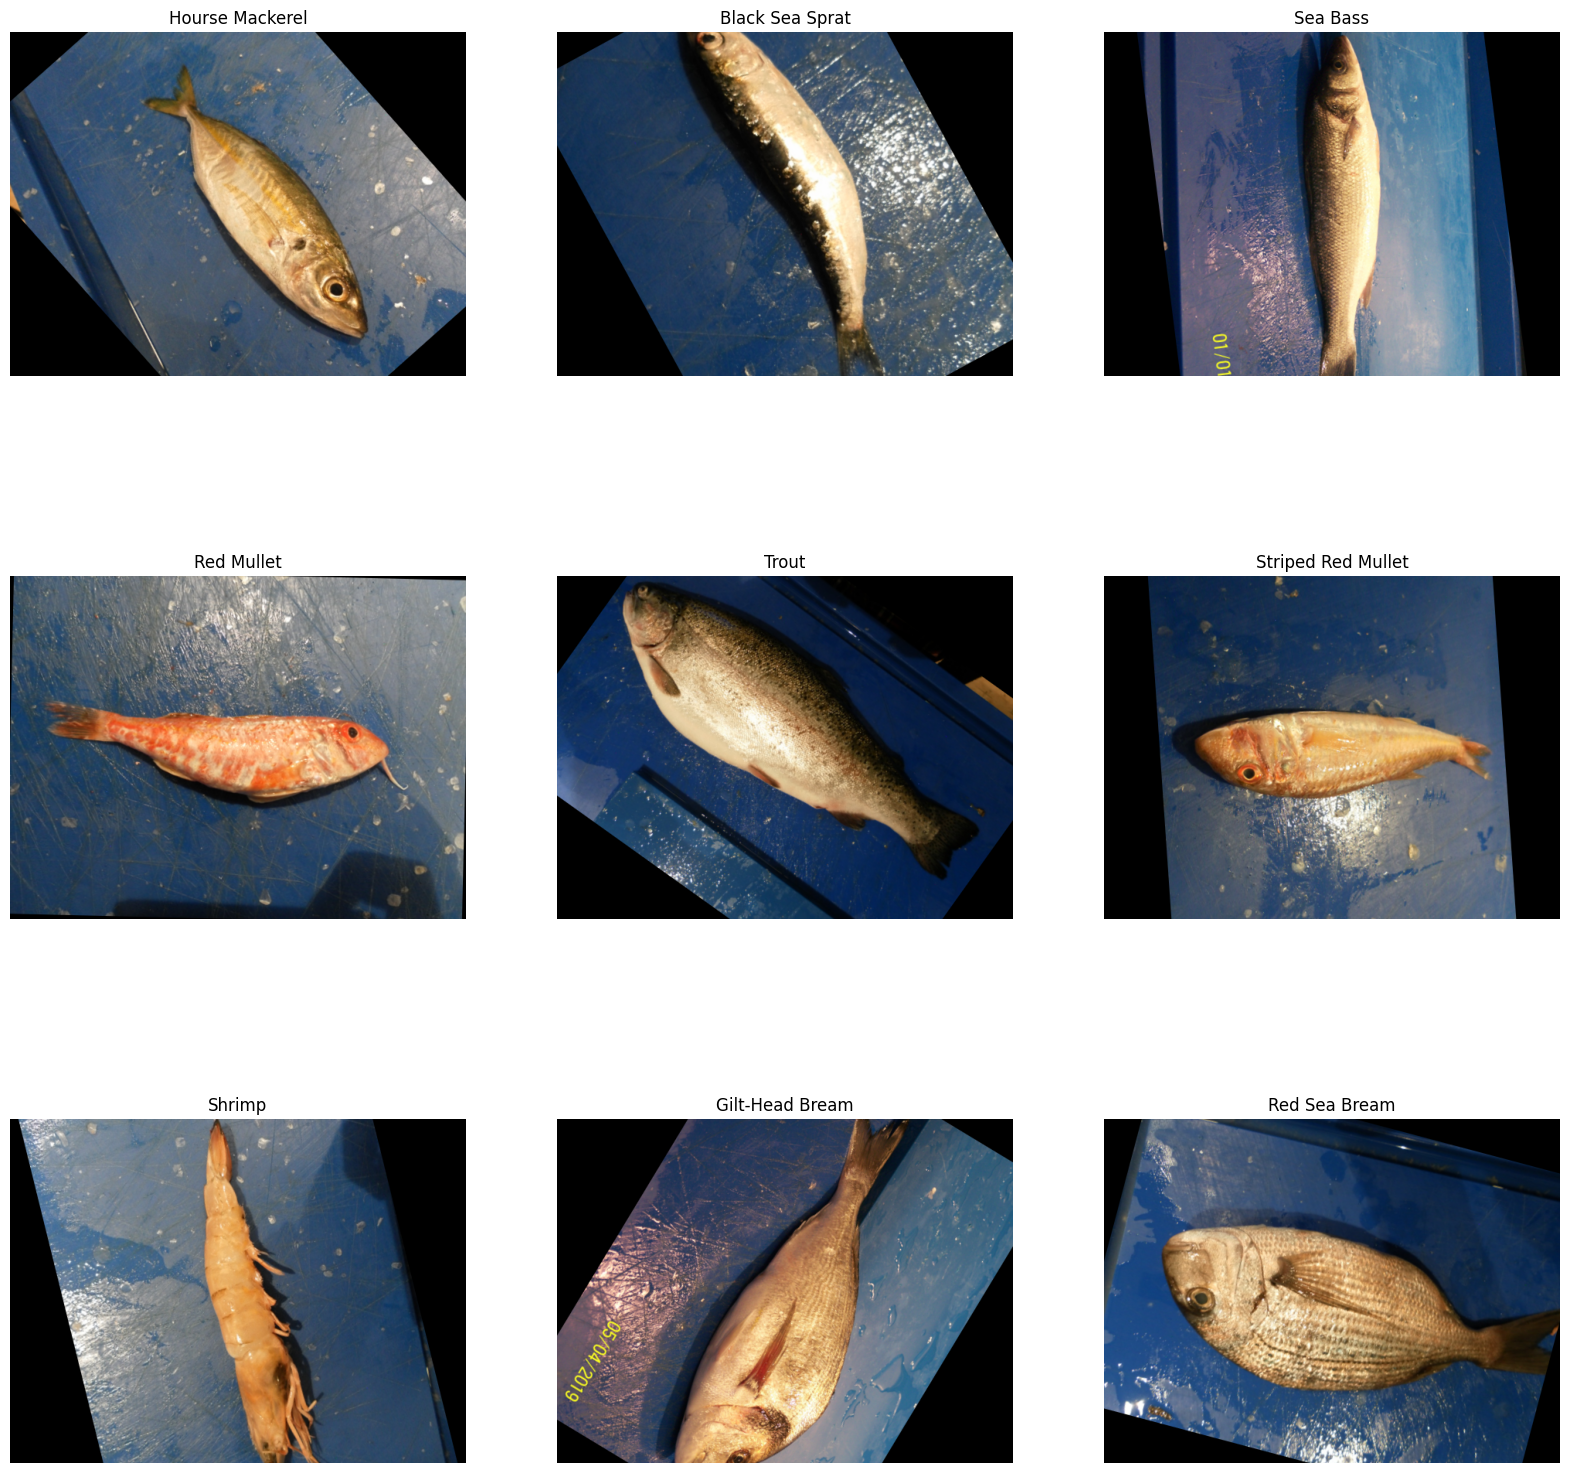

In [9]:
cn = 0
plt.figure(figsize=(20,20))
for unique_label in data['label'].unique():
    plt.subplot(3, 3, cn+1)
    plt.imshow(plt.imread(data[data['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    cn+=1

In [10]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)

In [11]:
print(train_data.shape)
print(test_data.shape)

(7200, 2)
(1800, 2)


# preprocessing and Generation

In [12]:
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [13]:
train_images = train_generator.flow_from_dataframe(dataframe=train_data, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='training')
val_images = train_generator.flow_from_dataframe(dataframe=train_data, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='validation' )
test_images = test_generator.flow_from_dataframe(dataframe=test_data, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=False )

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [14]:
display(train_images.class_indices)
display(val_images.class_indices)
display(test_images.class_indices)

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

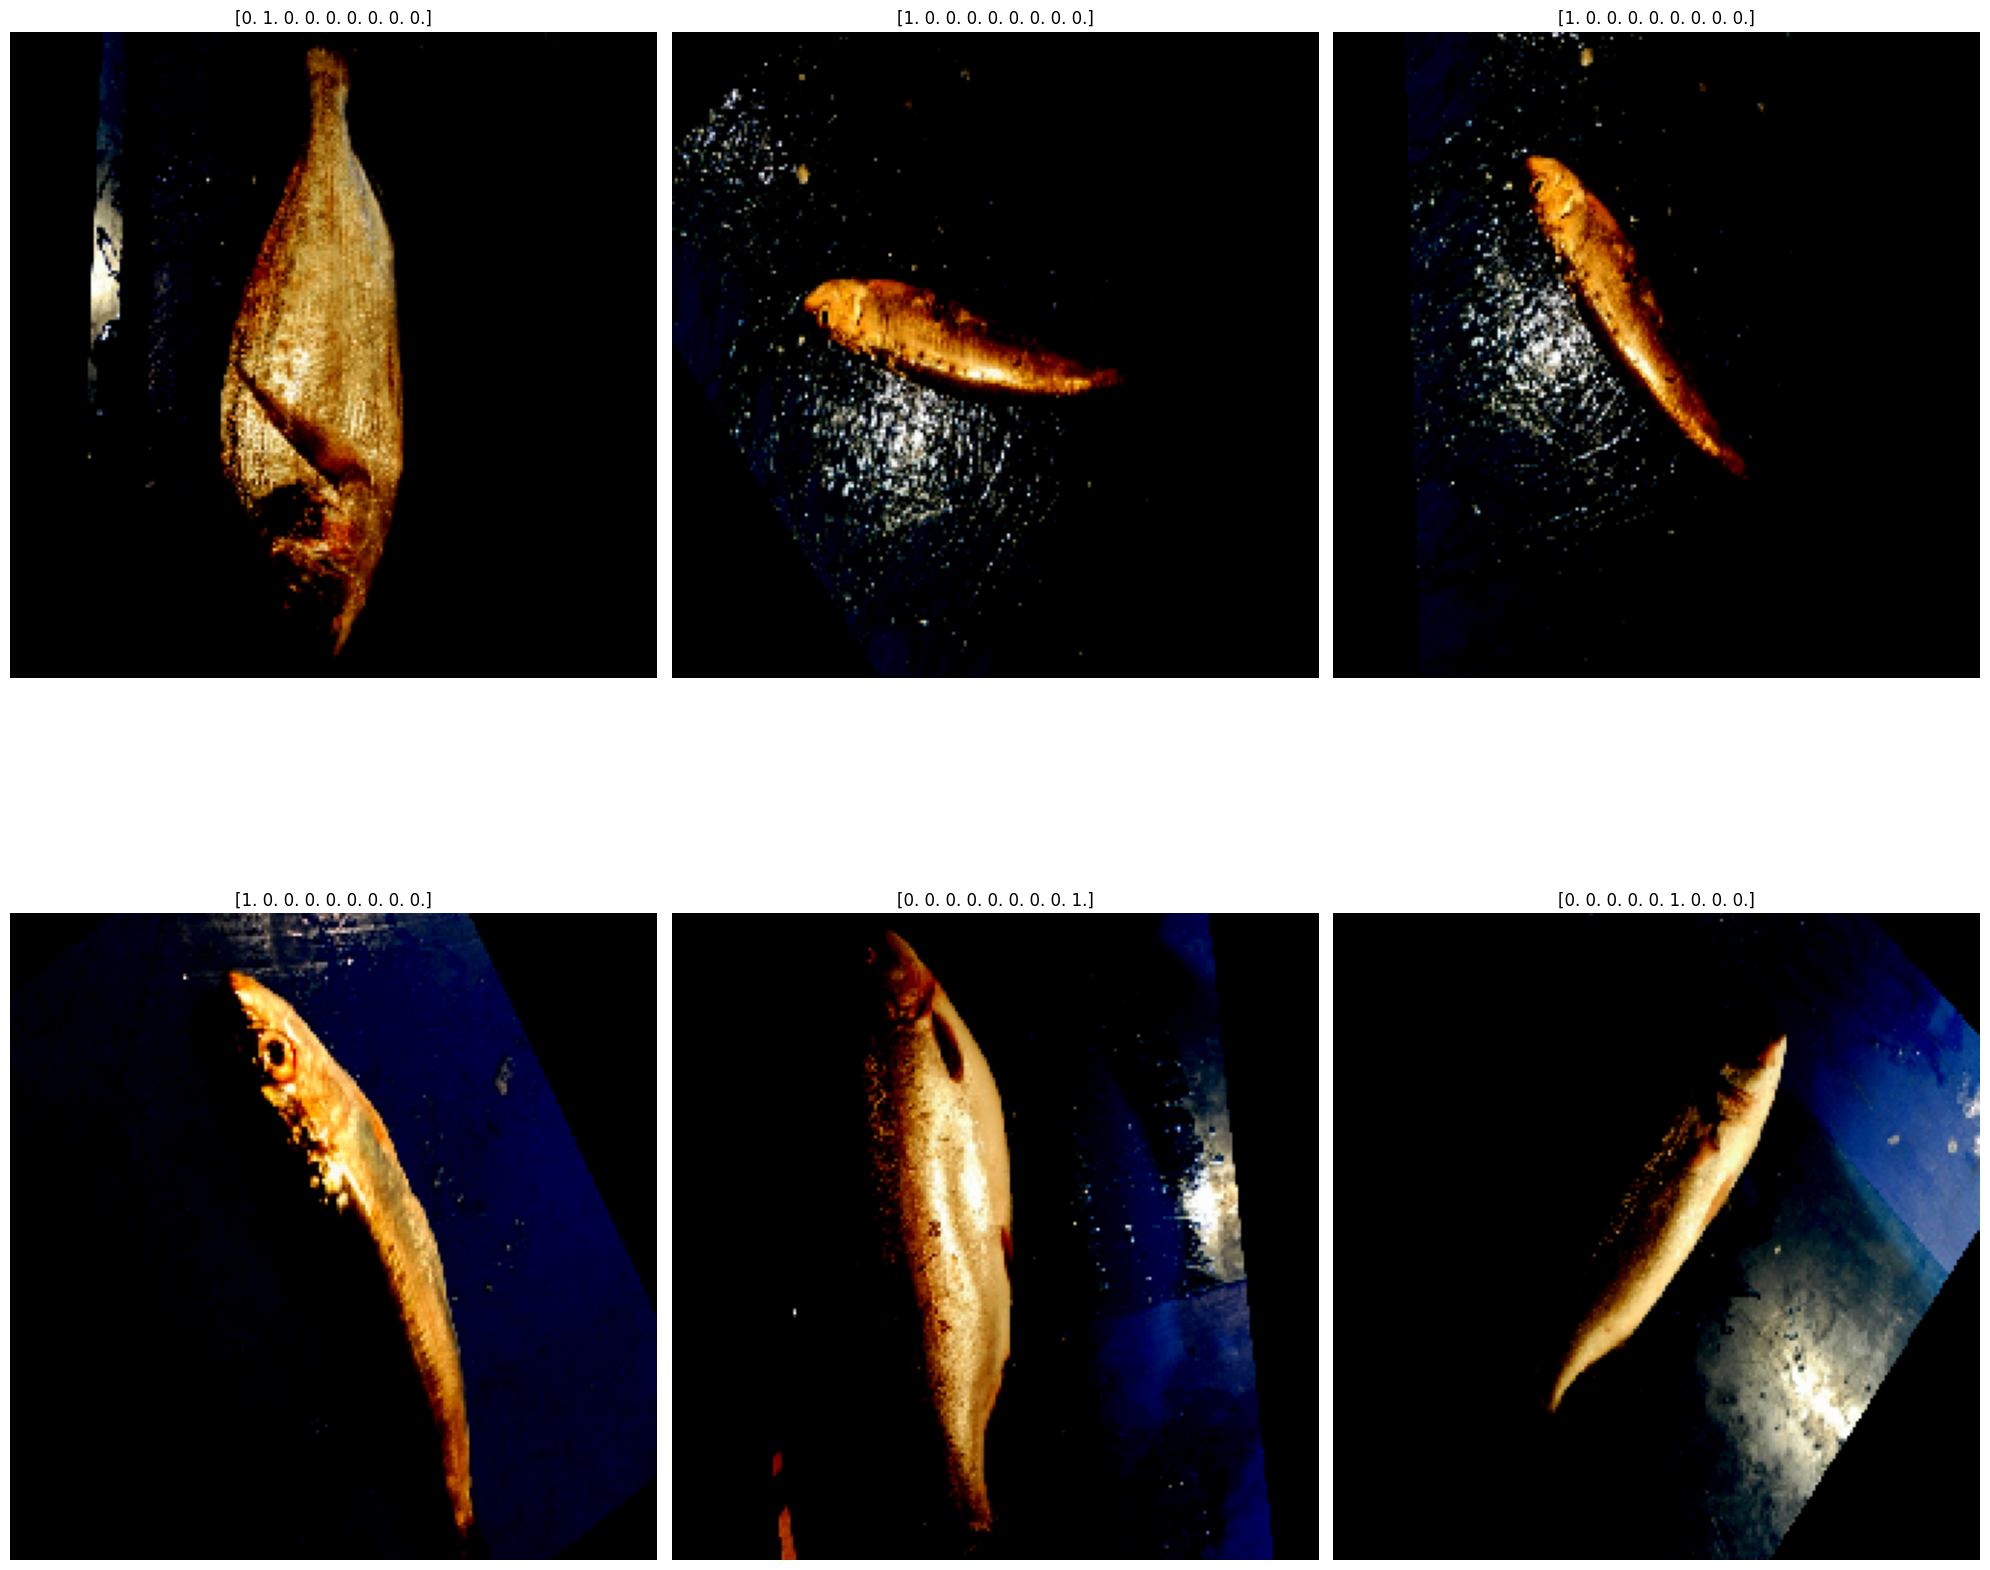

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,20))
ax = ax.flatten()

for j in range(6):
    img, label = next(test_images)  
    
    
    if isinstance(label, (list, np.ndarray)):
        label = label[0]
    
    if not isinstance(label, str):
        label = str(label)
    
    ax[j].imshow(img[0])  
    ax[j].set_title(label)  
    ax[j].axis('off')

plt.tight_layout()  
plt.show()  

# Build Model

In [16]:
 weights_path = '/kaggle/input/mobilenet-v2-keras-weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'

In [17]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [18]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=5)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

I0000 00:00:1726410720.757412      83 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


180/180 [==============================] - 125s 666ms/step - loss: 0.1748 - accuracy: 0.9524 - val_loss: 0.0406 - val_accuracy: 0.9896
Epoch 2/5
180/180 [==============================] - 77s 428ms/step - loss: 0.0113 - accuracy: 0.9977 - val_loss: 0.0176 - val_accuracy: 0.9958
Epoch 3/5
180/180 [==============================] - 77s 430ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 0.0118 - val_accuracy: 0.9958
Epoch 4/5
180/180 [==============================] - 77s 429ms/step - loss: 7.2529e-04 - accuracy: 1.0000 - val_loss: 0.0117 - val_accuracy: 0.9972
Epoch 5/5
180/180 [==============================] - 75s 417ms/step - loss: 4.4212e-04 - accuracy: 1.0000 - val_loss: 0.0106 - val_accuracy: 0.9965


In [19]:
model.evaluate(test_images, verbose=0)

[0.007805996108800173, 0.9977777600288391]

In [20]:
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

57/57 [==============================] - 20s 333ms/step


In [21]:
predict_data=test_data.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
predict_data['pred']=pred
predict_data['pred']=predict_data['pred'].apply(lambda x: labels[x])

In [22]:
predict_data=predict_data.reset_index(drop=True)
predict_data.head(10)
predict_data=predict_data.reset_index(drop=True)
predict_data.head(10)

path               label  \
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...     Gilt-Head Bream   
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...     Black Sea Sprat   
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...     Hourse Mackerel   
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...               Trout   
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...       Red Sea Bream   
5  /kaggle/input/a-large-scale-fish-dataset/Fish_...       Red Sea Bream   
6  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Striped Red Mullet   
7  /kaggle/input/a-large-scale-fish-dataset/Fish_...       Red Sea Bream   
8  /kaggle/input/a-large-scale-fish-dataset/Fish_...          Red Mullet   
9  /kaggle/input/a-large-scale-fish-dataset/Fish_...               Trout   

                 pred  
0     Gilt-Head Bream  
1     Black Sea Sprat  
2     Hourse Mackerel  
3               Trout  
4       Red Sea Bream  
5       Red Sea Bream  
6  Striped Red Mullet  
7       Red Sea Bream  
8          Red Mullet  
9               Trout

In [23]:
predict_data[predict_data['label']!=predict_data['pred']]

path               label  \
1354  /kaggle/input/a-large-scale-fish-dataset/Fish_...       Red Sea Bream   
1380  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Striped Red Mullet   
1604  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Striped Red Mullet   
1629  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Striped Red Mullet   

                 pred  
1354  Gilt-Head Bream  
1380           Shrimp  
1604           Shrimp  
1629           Shrimp

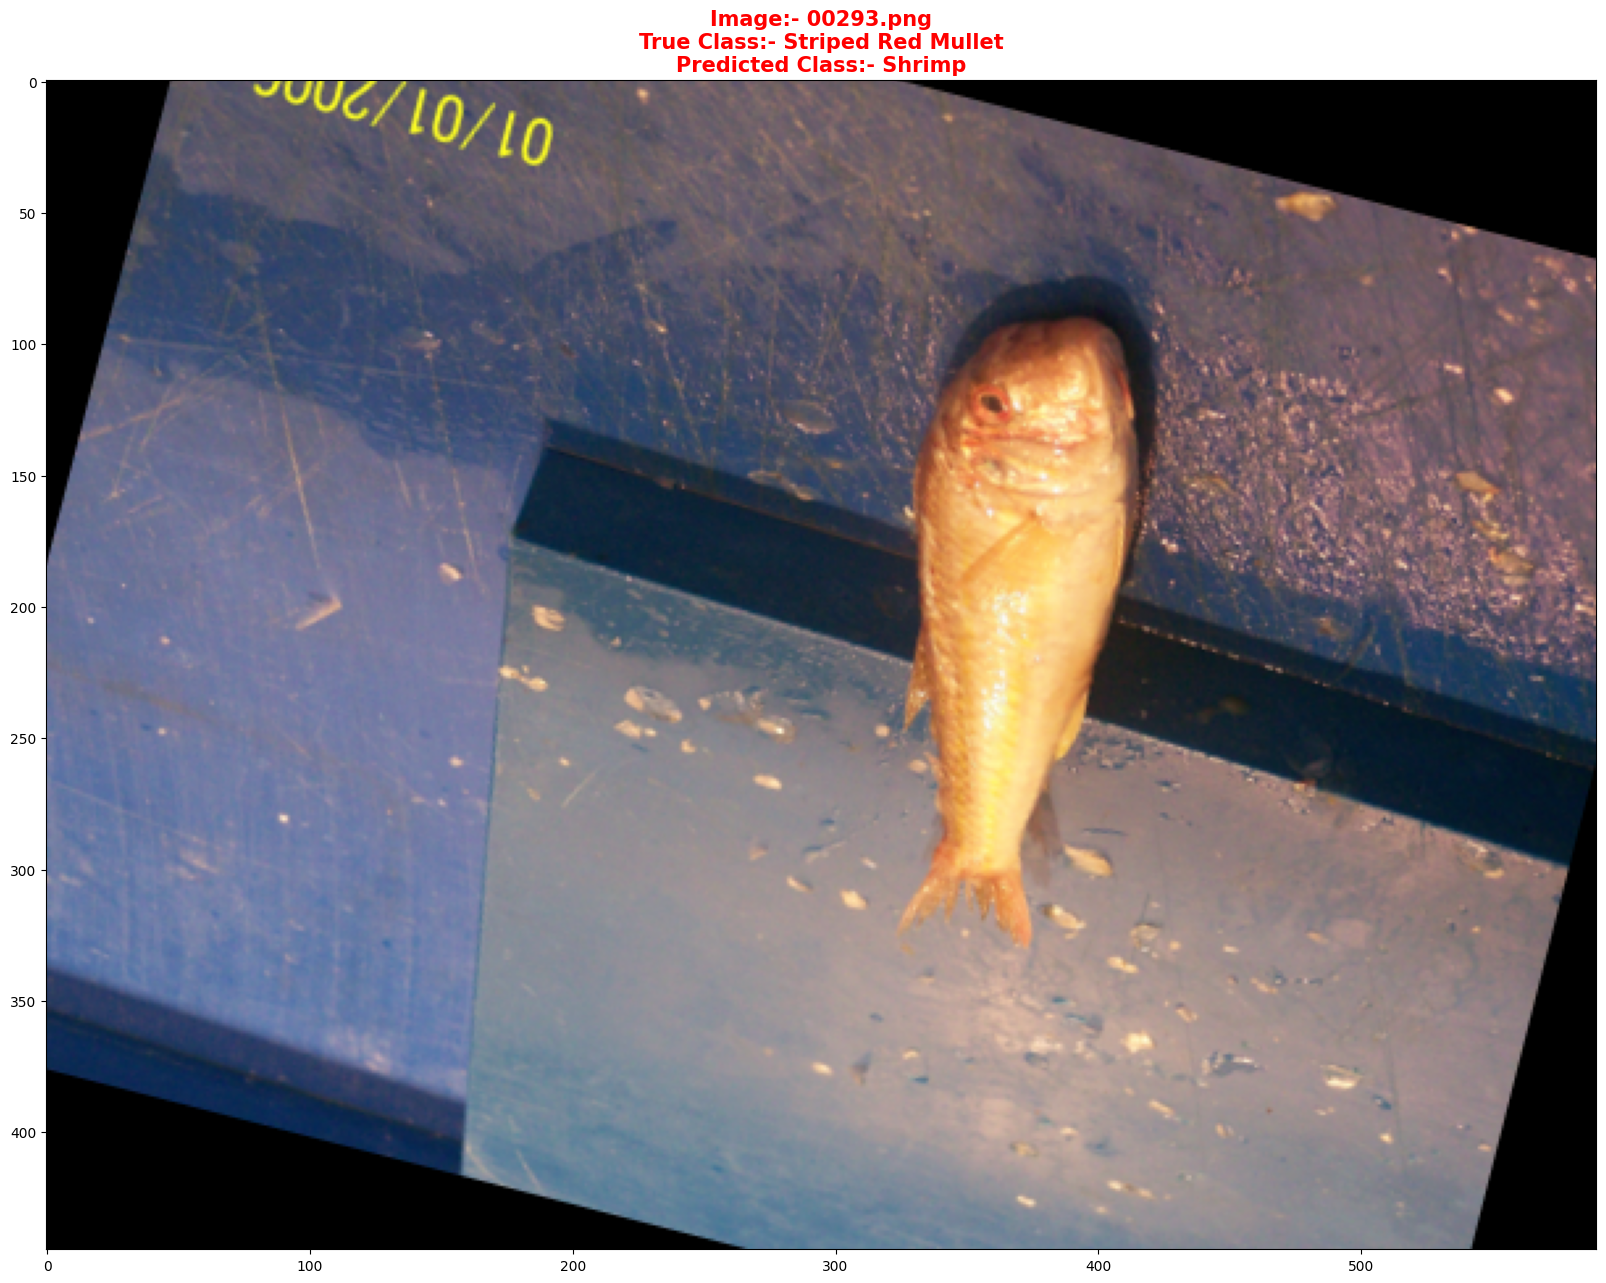

In [24]:
plt.figure(figsize=(20,20))
plt.imshow(plt.imread(predict_data.path[1604]))
title1 = predict_data.path[1604].split('/')[-2]
title2 = predict_data.path[1604].split('/')[-1]
title3 = predict_data.pred[1604]
plt.title(f'Image:- {title2}\nTrue Class:- {title1}\nPredicted Class:- {title3}', color = 'r', weight = 'bold', fontsize = 15)
plt.show()

Accuracy Score: 0.9977777777777778


<Axes: >

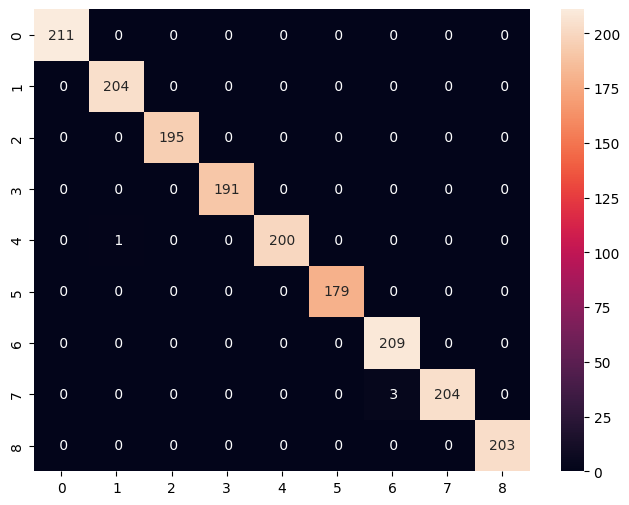

In [25]:
print(f"Accuracy Score: {accuracy_score(predict_data['label'],predict_data['pred'])}")
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(predict_data['label'],predict_data['pred']), annot=True, fmt='2d')

In [26]:
print(classification_report(predict_data['label'],predict_data['pred']))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       211
   Gilt-Head Bream       1.00      1.00      1.00       204
   Hourse Mackerel       1.00      1.00      1.00       195
        Red Mullet       1.00      1.00      1.00       191
     Red Sea Bream       1.00      1.00      1.00       201
          Sea Bass       1.00      1.00      1.00       179
            Shrimp       0.99      1.00      0.99       209
Striped Red Mullet       1.00      0.99      0.99       207
             Trout       1.00      1.00      1.00       203

          accuracy                           1.00      1800
         macro avg       1.00      1.00      1.00      1800
      weighted avg       1.00      1.00      1.00      1800

